In [1]:
# imports
import pandas as p                              # it's pandas
from sklearn.preprocessing import MinMaxScaler  # for features scaling
import Constants as c                           # constants
import Functions as f                           # plotting functions
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as po
import pickle
import folium
from folium.plugins import HeatMap
import webbrowser as wb
import hdbscan as hdbs


In [2]:
# Import dataframe from "out" folder
with open('../out/TREAD_out.pkl', 'rb') as file:
    df, trips_list, name_of_route = pickle.load(file)
# pick one random trip to fiddle with it
sample_trip = trips_list[73]
display(f"There are in total {df['trip_id'].max() + 1} separate trips")

'There are in total 45384 separate trips'

In [3]:
# some info about the dataframe
sample_trip.reset_index(inplace=True, drop=True)
# the above instruction sometimes adds a new column called 'index', which is subsequently removed
if 'index' in sample_trip.columns:
    print("Column \"Index\" removed")
    sample_trip.drop(['index'], axis=1, inplace=True)
display(sample_trip.head(3))
#display(df)
# current columns (aka features) of the dataset
print(df.columns)
display(df.info())

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,...,Draft,IsClassA,Avg_Speed,EstimatedStatus,IsInWP,IsInSignificantWP,Route,IsInRoute,group,trip_id
0,367745320,2019-01-22 00:04:54,20.7428,-156.8866,8.5,98.4,107.0,EXPEDITIONS SIX,60,15,...,NaN,True,5.27,sailing,None,<NA>,WP_61 - WP_96,True,1,29564
1,367745320,2019-01-22 00:05:58,20.7403,-156.8825,19.0,121.5,125.0,EXPEDITIONS SIX,60,15,...,NaN,True,15.48,sailing,WP_61,<NA>,WP_61 - WP_96,True,0,29564
2,367745320,2019-01-22 00:07:20,20.7370,-156.8761,18.4,96.2,95.0,EXPEDITIONS SIX,60,15,...,NaN,True,18.04,sailing,None,<NA>,WP_61 - WP_96,True,0,29564


Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
       'VesselName', 'VesselType', 'Status', 'Length', 'Width', 'Draft',
       'IsClassA', 'Avg_Speed', 'EstimatedStatus', 'IsInWP',
       'IsInSignificantWP', 'Route', 'IsInRoute', 'group', 'trip_id'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 5460702 entries, 0 to 2
Data columns (total 22 columns):
 #   Column             Dtype        
---  ------             -----        
 0   MMSI               int32        
 1   BaseDateTime       datetime64[s]
 2   LAT                float64      
 3   LON                float64      
 4   SOG                float64      
 5   COG                float64      
 6   Heading            float64      
 7   VesselName         string       
 8   VesselType         int16        
 9   Status             int8         
 10  Length             int16        
 11  Width              int16        
 12  Draft              float32      
 13  IsClassA           bool   

None

#### General Approach
1. Normalization (some features have different scales) (to be decided, probably not)
2. Features selection
3. Algorithm

In [4]:
# check which columns contain any null values
df.isnull().sum()

MMSI                       0
BaseDateTime               0
LAT                        0
LON                        0
SOG                        0
COG                        0
Heading                    0
VesselName            456248
VesselType                 0
Status                     0
Length                     0
Width                      0
Draft                3618047
IsClassA                   0
Avg_Speed                  0
EstimatedStatus            0
IsInWP               1278778
IsInSignificantWP    1734711
Route                      0
IsInRoute                  0
group                      0
trip_id                    0
dtype: int64

,trip_id,count
0,2411,180
1,2404,83
2,5580,62
3,29413,49
4,29829,48
...,...,...
282,30323,21
283,30246,20
284,30321,20
285,29962,14


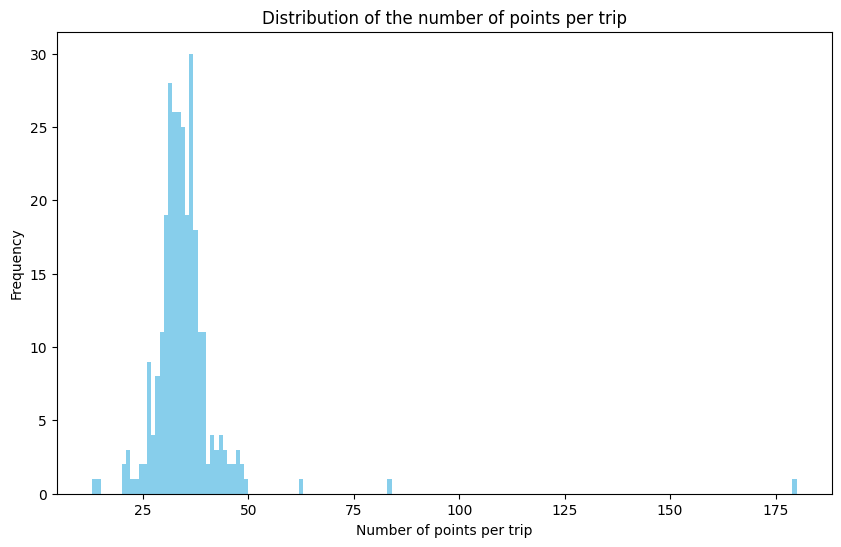

In [5]:
# all the trips of the chosen route are separated in a list
# create a single dataframe with all of them together
testDF = p.concat(trips_list, ignore_index=True, axis=0)
points_per_trip = testDF['trip_id'].value_counts().reset_index(name='count')

display(points_per_trip)

plt.figure(figsize=(10,6))
plt.hist(points_per_trip['count'], 
         bins=range(min(points_per_trip['count']), max(points_per_trip['count']) + 1, 1), # from, to, step
         color='skyblue')
plt.xlabel('Number of points per trip')
plt.ylabel('Frequency')
plt.title('Distribution of the number of points per trip')
plt.show()

In [10]:
# temp for testing
tempDF = testDF[testDF['trip_id'] == 2404]

plot = f.route_arrows_plot(inputDF=tempDF, color_criteria='Avg_Speed', scale_factor=0.0001)
po.plot(plot, auto_open=True)

/home/accazeta/Scrivania/Unibg/ZTesi Magistrale/workspace/AIS_data_analysis/src/Functions.py:241: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/accazeta/Scrivania/Unibg/ZTesi Magistrale/workspace/AIS_data_analysis/src/Functions.py:242: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



'temp-plot.html'

In [ ]:
from sklearn.neighbors import KernelDensity
import plotly.graph_objects as go

coords = testDF[['LAT', 'LON']].values

kde = KernelDensity(bandwidth=0.1, kernel='gaussian', metric="haversine").fit(coords)

# generate grid points for plotting
lat_min, lat_max = df['LAT'].min(), df['LAT'].max()
lon_min, lon_max = df['LON'].min(), df['LON'].max()

# create mesh grid for density estimation
lat_grid, lon_grid = np.mgrid[
    lat_min:lat_max:100j,       # the j is required as it is numpy's specific notation
    lon_min:lon_max:100j        # why? Don't know, ask numpy.
]

# combine grid points
grid_points = np.vstack([lat_grid.ravel(), lon_grid.ravel()]).T

# Evaluate density
log_density = kde.score_samples(grid_points)
density = np.exp(log_density).reshape(lat_grid.shape)

# Create an interactive Plotly heatmap
fig = go.Figure(data=[
    go.Densitymapbox(
        lat=testDF['LAT'],
        lon=testDF['LON'],
        z=density.flatten(),
        radius=10,
        colorscale='portland',
        showscale=True,
        colorbar=dict(title='Traffic Density')
    )
])
    
# Update layout for a map view
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox=dict(
        center=dict(
            lat=df['LAT'].mean(),
            lon=df['LON'].mean()
        ),
        zoom=10
    ),
    title=f'Vessel Traffic Density Heatmap for route {testDF.iloc[0, testDF.columns.get_loc("Route")]}',
    height=800
)

po.plot(fig, filename='vessel_traffic_density.html', auto_open=True)


'vessel_traffic_density.html'

Text(0.5, 1.0, 'Fit Values: 34.36 and 10.62')

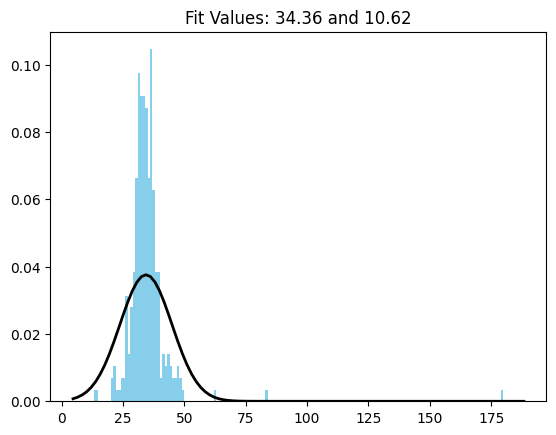

In [7]:
import scipy.stats as stats
# try to extract normal distribution
points_data = points_per_trip['count'].values
mu, std = stats.norm.fit(points_data)

plt.hist(points_data, 
         bins=range(min(points_per_trip['count']), max(points_per_trip['count']) + 1, 1),
         density=True,
         color='skyblue'
         )

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)

In [8]:
#another test
testDF = p.concat(trips_list, ignore_index=True, axis=0)
chosen_columns = ['LAT', 'LON', 'Avg_Speed', 'COG', 'Heading']
#chosen_columns = ['LAT', 'LON', 'Avg_Speed', 'COG', 'Heading', 'IsClassA']
chosen_data = testDF[chosen_columns]

from sklearn.mixture import GaussianMixture

lowest_bic = np.inf
best_gmm = None
n_clusters_range = range(1,11)


for cluster_num in n_clusters_range:
    gmm = GaussianMixture(n_components= cluster_num, random_state = 0)
    gmm.fit(chosen_data)
    bic = gmm.bic(chosen_data)

    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm = gmm

testDF['cluster'] = best_gmm.predict(chosen_data)

map = folium.Map(location=[testDF.LAT.mean(), testDF.LON.mean()], zoom_start=12)

colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen']

#plot
f.route_plot(inputDF=testDF, color_criteria='cluster', hover_data=chosen_columns, title=f'Route {name_of_route}')
# TODO fix this function below 
#f.route_clusters_plot(testDF)

AttributeError: 'numpy.ndarray' object has no attribute 'concat'

In [ ]:
# Select biggest clusters until 80% of points is reached
testDF['cluster'].value_counts()
total_points = testDF['cluster'].size
eighty_percent = int(total_points * 0.8)
display(total_points, eighty_percent)

groupedDF = testDF.groupby(by='cluster').size().reset_index(name='count',).sort_values(by='count', ascending=False)
groupedDF.reset_index(drop=True, inplace=True)
display(groupedDF)

partial_sum = 0
for index, row in groupedDF.iterrows():
    temp_value = row['count']
    if partial_sum + temp_value > eighty_percent:
        break
    else:
        partial_sum = partial_sum + temp_value

selected_clusters = groupedDF.iloc[:index+1, 0].to_list()

display(selected_clusters)

f.route_plot(testDF[testDF['cluster'].isin(selected_clusters)], color_criteria='cluster')
f.route_plot(testDF[testDF['cluster'].isin(set(groupedDF['cluster'].to_list()) - set(selected_clusters))], color_criteria='cluster')

9861

7888

,cluster,count
0,9,5003
1,0,2179
2,2,772
3,6,727
4,5,548
5,3,290
6,1,183
7,4,81
8,7,47
9,8,31


[9, 0, 2]

##### Test with hdbscan

In [ ]:
testDF = p.concat(trips_list, ignore_index=True, axis=0)
chosen_columns = ['LAT', 'LON', 'Avg_Speed', 'COG', 'Heading', 'IsClassA']
chosen_data = testDF[chosen_columns]

# inizitalize h-dbscan object with parameters. TODO: test multiple parameters combinations
h_dbscan = hdbs.HDBSCAN(min_cluster_size=30,
                        cluster_selection_epsilon=0.01,
                        max_cluster_size=10_000)

h_labels = h_dbscan.fit_predict(
                    X=testDF[['LAT','LON']]
                    )

print(str(h_dbscan) + " len: " + str(len(h_labels)) + ", num of clusters: " + str(max(h_labels)))

# Add labels to the dataframe
testDF['Label'] = h_labels

display(testDF)

# Show the result of h-dbscan on a map

clusteredPointsDF = testDF[(testDF['Label'] != -1)].copy()
outliersDF = testDF[testDF['Label'] == -1].copy()

clusteredPointsDF = clusteredPointsDF.groupby(by=['LAT', 'LON', 'Label']).size().reset_index(name='Weight')

# plot points and clusters
f.points_plotter(clustered=clusteredPointsDF,
               not_clustered=outliersDF,
               model=h_dbscan)


HDBSCAN(cluster_selection_epsilon=0.01, max_cluster_size=10000,
        min_cluster_size=30) len: 9861, num of clusters: 1


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,...,IsClassA,Avg_Speed,EstimatedStatus,IsInWP,IsInSignificantWP,Route,IsInRoute,group,route_id,Label
0,338143427,2019-01-02 19:53:11,20.7387,-156.8818,6.9,116.3,511.0,KOA,36,99,...,False,6.38,sailing,WP_61,<NA>,WP_61 - WP_96,True,1,2404,0
1,338143427,2019-01-02 19:58:08,20.7386,-156.8725,6.3,87.2,511.0,KOA,36,99,...,False,6.34,sailing,None,<NA>,WP_61 - WP_96,True,0,2404,0
2,338143427,2019-01-02 19:59:10,20.7391,-156.8707,6.7,64.2,511.0,KOA,36,99,...,False,6.13,sailing,None,<NA>,WP_61 - WP_96,True,0,2404,0
3,338143427,2019-01-02 20:00:10,20.7401,-156.8690,6.8,51.2,511.0,KOA,36,99,...,False,6.77,sailing,None,<NA>,WP_61 - WP_96,True,0,2404,0
4,338143427,2019-01-02 20:02:08,20.7418,-156.8659,3.2,73.6,511.0,KOA,36,99,...,False,6.16,sailing,None,<NA>,WP_61 - WP_96,True,0,2404,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9856,367745320,2019-03-31 21:10:27,20.8593,-156.6950,21.2,51.3,52.0,EXPEDITIONS SIX,60,15,...,True,20.64,sailing,WP_96,<NA>,WP_61 - WP_96,True,0,30323,1
9857,367745320,2019-03-31 21:11:32,20.8635,-156.6897,21.7,54.9,56.0,EXPEDITIONS SIX,60,15,...,True,21.62,sailing,WP_96,<NA>,WP_61 - WP_96,True,0,30323,1
9858,367745320,2019-03-31 21:16:20,20.8708,-156.6802,3.7,8.9,18.0,EXPEDITIONS SIX,60,15,...,True,8.64,sailing,WP_96,<NA>,WP_61 - WP_96,True,0,30323,1
9859,367745320,2019-03-31 21:17:32,20.8720,-156.6792,0.7,119.5,332.0,EXPEDITIONS SIX,60,15,...,True,4.57,sailing,WP_96,<NA>,WP_61 - WP_96,True,0,30323,1
